In [1]:
%load_ext autoreload
%autoreload

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import prim
import seaborn as sns
#from sklearn import mixture
import os
#from clustering_and_prim_tools import *
#from SALib.analyze import sobol
#from SALib.sample import saltelli

In [4]:
%matplotlib inline

In [5]:
sns.set_context("poster",rc={"font.size": 28})
sns.set_style("whitegrid")

In [28]:
rootfolder = "C:\\Users\\WB451855\OneDrive - WBG\\!infra_needs_data\\transport_cired_output_data\\"

invfolder = rootfolder+"outputs_investments_module_billionusd/"
imaclimfolder = rootfolder+"outputs_Imaclim/"
physicalinfrafolder = rootfolder+"outputs_investments_module_physical_stock/"


# First I look at the results from the Imaclim model only (output = transport activity but no investment need)

### data prep

In [7]:
os.listdir(imaclimfolder)

['results_transports_Imaclim_ASIA.csv',
 'results_transports_Imaclim_CIS.csv',
 'results_transports_Imaclim_LAM.csv',
 'results_transports_Imaclim_MAF.csv',
 'results_transports_Imaclim_OCDE.csv',
 'results_transports_Imaclim_WORLD.csv']

In [8]:
pd.options.display.max_seq_items = 2000

In [18]:
all_ima_data = pd.DataFrame()
for myfilename in os.listdir(imaclimfolder):
    if "WORLD" in myfilename:
        continue
    myfile = pd.read_csv(imaclimfolder+"\\"+myfilename,sep=";")
    myinfo = myfilename.replace(".csv",'').split("_")
    myfile["region"] = myinfo[3]
    all_ima_data = all_ima_data.append(myfile)

In [19]:
all_ima_data.Variable.unique()

array(['Population', 'CO2_em_tot', 'CO2_em_trans', 'PIB',
       'passenger_activity', 'freight_activity', 'pkm_OT', 'pkm_auto',
       'pkm_air', 'fret_air', 'fret_OT', 'fret_mer'], dtype=object)

In [20]:
indexes_ima = ['//combi', 'ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'ind_taxexo', 'ind_recycl',
       'ind_taxmax', 'Variable', 'Unit','region']

In [21]:
indexes_ima2 = ['ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'ind_taxexo', 'ind_recycl',
       'ind_taxmax', 'Variable','region','year']

In [22]:
all_ima_data = all_ima_data.set_index(indexes_ima)
all_ima_data.columns.name='year'
all_ima_data = all_ima_data.stack('year')
all_ima_data.name = 'value'
all_ima_data = all_ima_data.reset_index('year')
all_ima_data['year'] = all_ima_data.year.astype("int64")
all_ima_data = all_ima_data.loc[(all_ima_data.year>2014)&(all_ima_data.year<2031),:]

In [23]:
all_ima_data.set_index("year",append=True).unstack("Variable")["value"]["PIB"].dropna();

In [24]:
out = all_ima_data.reset_index().drop(['Unit','//combi'],axis=1).set_index(indexes_ima2).unstack('Variable').value

In [25]:
out.columns

Index(['CO2_em_tot', 'CO2_em_trans', 'PIB', 'Population', 'freight_activity',
       'fret_OT', 'fret_air', 'fret_mer', 'passenger_activity', 'pkm_OT',
       'pkm_air', 'pkm_auto'],
      dtype='object', name='Variable')

In [26]:
to_merge = out.reset_index().set_index([x for x in indexes_ima2 if x not in ["Variable"]])["PIB"]

# Now I look at a different dataset that contains investment needs

In [27]:
indexes_inv = ['combi', 'ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
        'ur_ideal', 'urt_ideal','delay','costs_evolution_road', 'costs_evolution_rail']

## dataset for summing all dev regions and calculating cost as % of GDP for all regions together

In [29]:
all_data_global3 = pd.read_csv(rootfolder+"summarize_global_costs.csv")

In [30]:
all_data_global3.sample(3)

,combi,ind_climat,ind_growth,ind_mitig,ind_trans_A,ind_trans_S,ind_trans_I,ind_trans_F,modal_scenario,ur_ideal,urt_ideal,delay,costs_evolution_road,costs_evolution_rail,costtype,transpmode,divided_by_gdp
131552,61,0,2,2,2,2,1,1,1,900,5000,65,2,0,maint,hsr,0.000030
289953,135,2,2,1,1,2,2,1,0,600,5000,65,2,0,maint,rail,0.000978
500801,328,4,2,1,1,2,2,2,1,900,5000,35,1,1,maint,brt,0.000117


## IMPORTANT: we drop some unrealistic scenarios

In [32]:
all_data_global3 = all_data_global3.loc[all_data_global3.ur_ideal>300,:]

In [33]:
all_data_global = all_data_global3.set_index(indexes_inv+["costtype","transpmode"])

In [34]:
all_data_global = all_data_global.stack().unstack("transpmode")
all_data_global["rail+high speed rail"] = all_data_global["rail"]+all_data_global['hsr']
all_data_global["allmodes"] = all_data_global["rail"]+all_data_global['hsr']+all_data_global["air"]+all_data_global['brt']+all_data_global['road']


### cost in % GDP for all developing countries for new capital

In [35]:
all_data_global.reset_index("ind_climat").ind_climat.unique()

array([0, 2, 4], dtype=int64)

0 = no climate change mitigation constraint, 2 = 3 degrees scenarios, 4 = 2 degrees scenario

In [36]:
all_data_global.reset_index("urt_ideal").urt_ideal.unique()

array([ 5000, 30000], dtype=int64)

In [37]:
all_data_global.reset_index("modal_scenario").modal_scenario.unique()

array([0, 1], dtype=int64)

1=shift to rail

In [56]:
all_data_global.reset_index("ind_mitig").ind_mitig.unique()

array([1, 2], dtype=int64)

Below I drop maintenance to see only capital investments

In [66]:
100*all_data_global.allmodes.drop("maint",level="costtype").describe(percentiles=[0.05,.25, .5, .75,0.95])

count    4.147200e+06
mean     1.510753e+00
std      5.231689e-01
min      5.319469e-01
5%       8.333555e-01
25%      1.093381e+00
50%      1.390742e+00
75%      1.891151e+00
95%      2.485996e+00
max      3.312571e+00
Name: allmodes, dtype: float64

Below I also drop the scenarios with no climate change mitigation objective

In [67]:
100*all_data_global.allmodes.drop(0,level="ind_climat").drop("maint",level="costtype").describe(percentiles=[0.05,.25, .5, .75,0.95])

count    2.764800e+06
mean     1.520539e+00
std      5.397659e-01
min      5.319469e-01
5%       8.083811e-01
25%      1.090250e+00
50%      1.401211e+00
75%      1.923894e+00
95%      2.514399e+00
max      3.312571e+00
Name: allmodes, dtype: float64

### cost in % GDP for all developing countries for maintenance

In [73]:
100*all_data_global.allmodes.drop("new",level="costtype").describe(percentiles=[0.05,.25, .5, .75,0.95])

count    4.147200e+06
mean     1.486771e+00
std      2.118261e-01
min      1.060687e+00
5%       1.161807e+00
25%      1.314803e+00
50%      1.473272e+00
75%      1.659537e+00
95%      1.827147e+00
max      2.082881e+00
Name: allmodes, dtype: float64

## dataset for exploring by region

In [39]:
all_data = pd.read_csv("C:\\Users\\WB451855\\OneDrive - WBG\\!infra_needs_data\\transport_cired_output_data\\"+"summarize_costs.csv")

In [40]:
all_data.columns

Index(['combi', 'ind_climat', 'ind_growth', 'ind_mitig', 'ind_trans_A',
       'ind_trans_S', 'ind_trans_I', 'ind_trans_F', 'modal_scenario',
       'ur_ideal', 'urt_ideal', 'delay', 'costs_evolution_road',
       'costs_evolution_rail', 'costtype', 'transpmode', 'region',
       'divided_by_gdp', 'value', 'disc_value', 'discounted_gdp'],
      dtype='object')

In [41]:
indexes_inv2 = ["costtype","transpmode","region"]

In [42]:
all_data.divided_by_gdp.describe()

count    3.110400e+06
mean     3.086226e-03
std      6.557811e-03
min      0.000000e+00
25%      1.579677e-05
50%      2.207328e-04
75%      1.479827e-03
max      5.796029e-02
Name: divided_by_gdp, dtype: float64

### IMPORTANT: drop the unrealistic scenarios

In [44]:
all_data = all_data.loc[all_data.ur_ideal>300,:]

In [45]:
all_data = all_data.set_index(indexes_inv+indexes_inv2)
all_data.columns.name = "columns"
all_data = all_data.stack().unstack("transpmode")
all_data["rail+high speed rail"] = all_data["rail"]+all_data['hsr']
all_data["allmodes"] = all_data["rail"]+all_data['hsr']+all_data["air"]+all_data['brt']+all_data['road']

In [46]:
all_data.sample(3)

,,,,,,,,,,,,,,,,transpmode,air,brt,hsr,rail,road,rail+high speed rail,allmodes
combi,ind_climat,ind_growth,ind_mitig,ind_trans_A,ind_trans_S,ind_trans_I,ind_trans_F,modal_scenario,ur_ideal,urt_ideal,delay,costs_evolution_road,costs_evolution_rail,costtype,region,columns,,,,,,,
309,4,1,2,1,2,1,1,0,600,5000,35,0,1,new,CIS,discounted_gdp,26861.311796,26861.311796,26861.311796,26861.311796,26861.311796,53722.623592,134306.558980
4,0,1,1,1,1,2,2,0,900,30000,65,0,1,maint,ASIA,disc_value,6.526860,2.950581,52.273148,96.545125,2677.983665,148.818273,2836.279380
56,0,2,2,1,2,2,2,0,900,5000,65,1,1,new,MAF,discounted_gdp,62566.650101,62566.650101,62566.650101,62566.650101,62566.650101,125133.300202,312833.250504


In [47]:
all_data.stack().reset_index("transpmode").transpmode.unique()

array(['air', 'brt', 'hsr', 'rail', 'road', 'rail+high speed rail',
       'allmodes'], dtype=object)

## numbers and graphs for report

In [58]:
bob2 = all_data.divided_by_gdp.unstack("transpmode").drop(['rail','hsr'],axis=1).stack().unstack("costtype")["new"]
bob2 = bob2.reset_index()
#bob2 = bob2.loc[bob2.region!="OCDE",:]
bob2["region"] = bob2.region.replace({"MAF":"Middle East\nand Africa",\
                                      "LAM":"Latin America\nand Caribbean",\
                                      "CIS":"Former\nSoviet Union",\
                                      "ASIA":"Asia",\
                                      "OCDE":"OECD"})
bob2["new"] = 100*bob2.new

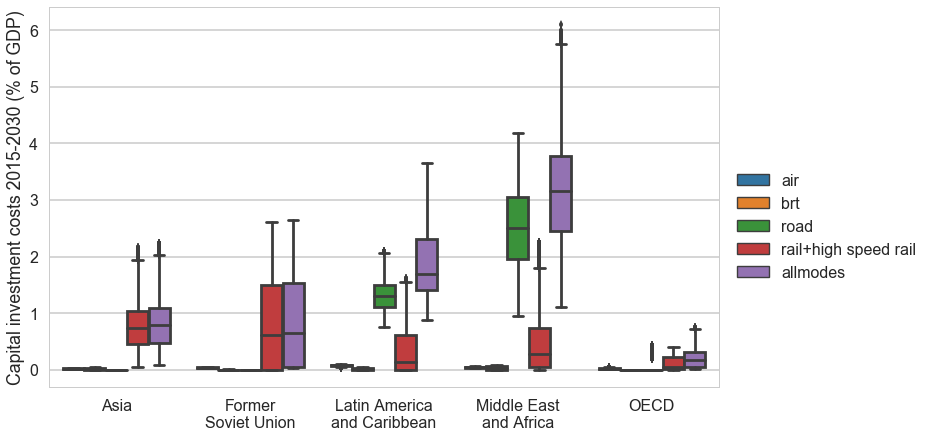

In [59]:
fig3, ax3 = plt.subplots()
sns.boxplot(x="region",y="new",hue="transpmode",data=bob2,ax=ax3)
fig3.set_size_inches(12, 7)
ax3.set_xlabel("")
ax3.set_ylabel("Capital investment costs 2015-2030 (% of GDP)")
plt.legend(title="",bbox_to_anchor=(1.005, 0.6))
plt.savefig("imaclim_per_region_mode_share_gdp.png",ddpi=300,bbox_inches="tight")
plt.savefig("imaclim_per_region_mode_share_gdp.pdf")

In [97]:
all_data_global.sample(2)

,,,,,,,,,,,,,,,transpmode,air,brt,hsr,rail,road,rail+high speed rail,allmodes
combi,ind_climat,ind_growth,ind_mitig,ind_trans_A,ind_trans_S,ind_trans_I,ind_trans_F,modal_scenario,ur_ideal,urt_ideal,delay,costs_evolution_road,costs_evolution_rail,costtype,,,,,,,,
317,4,1,2,2,2,1,1,1,600,5000,65,0,1,maint,divided_by_gdp,0.000074,0.000094,0.000181,0.001184,0.012534,0.001365,0.014068
107,2,1,1,2,1,2,1,0,600,5000,65,0,2,maint,divided_by_gdp,0.000072,0.000028,0.000153,0.000876,0.013111,0.001030,0.014242


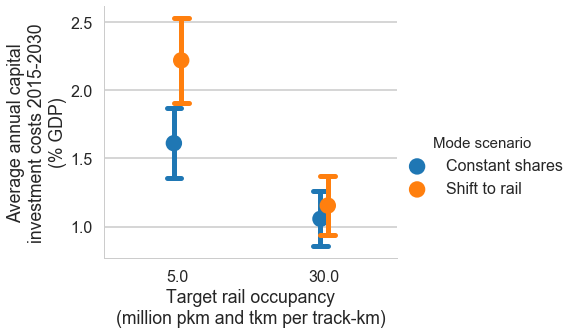

In [72]:
bob3 = all_data_global.allmodes.unstack("costtype")["new"].reset_index()
bob3['modal_scenario'] = bob3.modal_scenario.replace({0:"Constant shares",1:"Shift to rail"})

#transforms sum in annual average
bob3['new'] = 100*bob3.new

bob3['urt_ideal'] = 1/1000*bob3.urt_ideal

g = sns.factorplot(x="urt_ideal",y="new",hue="modal_scenario",dodge=True,ci='sd',join=False,\
              kind="point",capsize=0.1,data=bob3,errwidth=5, size=5, aspect=1.2,\
                  legend=False)



#g = sns.factorplot(x="modal_scenario",y="allmodes",hue="urt_ideal", kind='box',\
#              data=bob3, size=5, aspect=1.5,\
#                  legend=False)

g.set_axis_labels("Target rail occupancy\n(million pkm and tkm per track-km)", "Average annual capital\ninvestment costs 2015-2030\n(% GDP)")
g.add_legend(title="Mode scenario")

plt.savefig("imaclim_dev_world_unc_pcpib.png",ddpi=300,bbox_inches="tight")
plt.savefig("imaclim_dev_world_unc_pcpib.pdf")

In [84]:
all_data.allmodes.unstack("columns").divided_by_gdp.unstack("region")["MAF"].unstack("costtype")["new"].unstack("ur_ideal").describe()

ur_ideal,600,900
count,20736.000000,20736.000000
mean,0.037351,0.026132
std,0.007272,0.007353
min,0.022941,0.011031
25%,0.031871,0.020912
50%,0.035706,0.024625
75%,0.041991,0.030687
max,0.061068,0.046140


## Preferred scenario

In [51]:
best_scenario = all_data_global.reset_index()
select = (best_scenario.urt_ideal==30000)&(best_scenario.modal_scenario==1)&(best_scenario.ind_climat==2)&(best_scenario.ind_mitig==2)&(best_scenario.ur_ideal==600)&\
(best_scenario.ind_trans_A==2)&(best_scenario.ind_trans_S==2)&(best_scenario.ind_trans_I==2)&(best_scenario.ind_trans_F==2)&(best_scenario.delay==35)&\
(best_scenario.costs_evolution_road==2)&(best_scenario.costs_evolution_rail==2)&(best_scenario.ind_growth==2)

best_scenario = best_scenario.loc[select,:]

In [52]:
best_scenario[["costtype","allmodes"]]

transpmode,costtype,allmodes
45988,maint,0.012640
45989,new,0.012908


## preferred scenario by region

In [55]:
best_scenario = all_data["allmodes"].unstack("columns")['divided_by_gdp'].reset_index()

select = (best_scenario.urt_ideal==30000)&(best_scenario.modal_scenario==1)&(best_scenario.ind_climat==2)&(best_scenario.ind_mitig==2)&(best_scenario.ur_ideal==600)&\
(best_scenario.ind_trans_A==2)&(best_scenario.ind_trans_S==2)&(best_scenario.ind_trans_I==2)&(best_scenario.ind_trans_F==2)&(best_scenario.delay==35)&\
(best_scenario.costs_evolution_road==2)&(best_scenario.costs_evolution_rail==2)&(best_scenario.ind_growth==2)

best_scenario = best_scenario.loc[select,:]

In [56]:
100*best_scenario.set_index(["region","costtype"]).divided_by_gdp.unstack("costtype")

costtype,maint,new
region,,
ASIA,1.570369,0.768812
CIS,1.787916,0.041838
LAM,0.571919,1.432602
MAF,0.965223,3.202140
OCDE,0.945221,0.050970


## additional analyses on maintenance

In [70]:
paul = all_data.divided_by_gdp.unstack("transpmode").drop(['rail','hsr'],axis=1)
paul = paul.reset_index()
#paul = paul.loc[paul.region!="OCDE",:]
#paul["region"] = paul.region.replace({"MAF":"MNA+SSA","LAM":"LAC","CIS":"ECA","ASIA":"SAS+EAP","OCDE":"OECD"})

paul["region"] = paul.region.replace({"MAF":"Middle East\nand Africa",\
                                      "LAM":"Latin America\nand Caribbean",\
                                      "CIS":"Former\nSoviet Union",\
                                      "ASIA":"Asia",\
                                      "OCDE":"OECD"})

paul["allmodes"] = 100*paul["allmodes"]

In [76]:
paul.loc[paul.costtype=="maint",["allmodes","region"]].groupby("region").min()

transpmode,allmodes
region,
Asia,1.286067
Former\nSoviet Union,1.518279
Latin America\nand Caribbean,0.493271
Middle East\nand Africa,0.773341
OECD,0.859854


In [78]:
paul.loc[paul.costtype=="maint",["allmodes","region"]].groupby("region").max()

transpmode,allmodes
region,
Asia,2.883967
Former\nSoviet Union,2.791344
Latin America\nand Caribbean,0.887510
Middle East\nand Africa,1.394999
OECD,1.190104


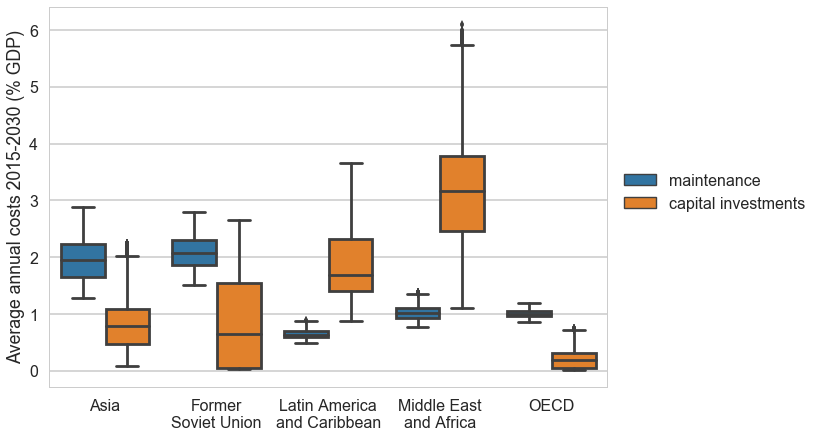

In [72]:
fig2, ax2 = plt.subplots()
sns.boxplot(x="region",y="allmodes",hue="costtype",data=paul.replace({"maint":"maintenance","new":"capital investments"}),ax=ax2)
fig2.set_size_inches(10, 7)
ax2.set_xlabel("")
ax2.set_ylabel("Average annual costs 2015-2030 (% GDP)")
plt.legend(title="",bbox_to_anchor=(1.005, 0.6))
plt.savefig("imaclim_per_region_share_gdp_k_maint.png",ddpi=300,bbox_inches="tight")
plt.savefig("imaclim_per_region_share_gdp_k_maint.pdf")